In [7]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object): # for adding noise to the action prediced by the policy network
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b



class Memory: # contains replay buffer/experience array
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

DDPG uses four neural networks:

1.   a Q network,
2.   a deterministic policy network,
3.   a target Q network, and
4.   a target policy network.



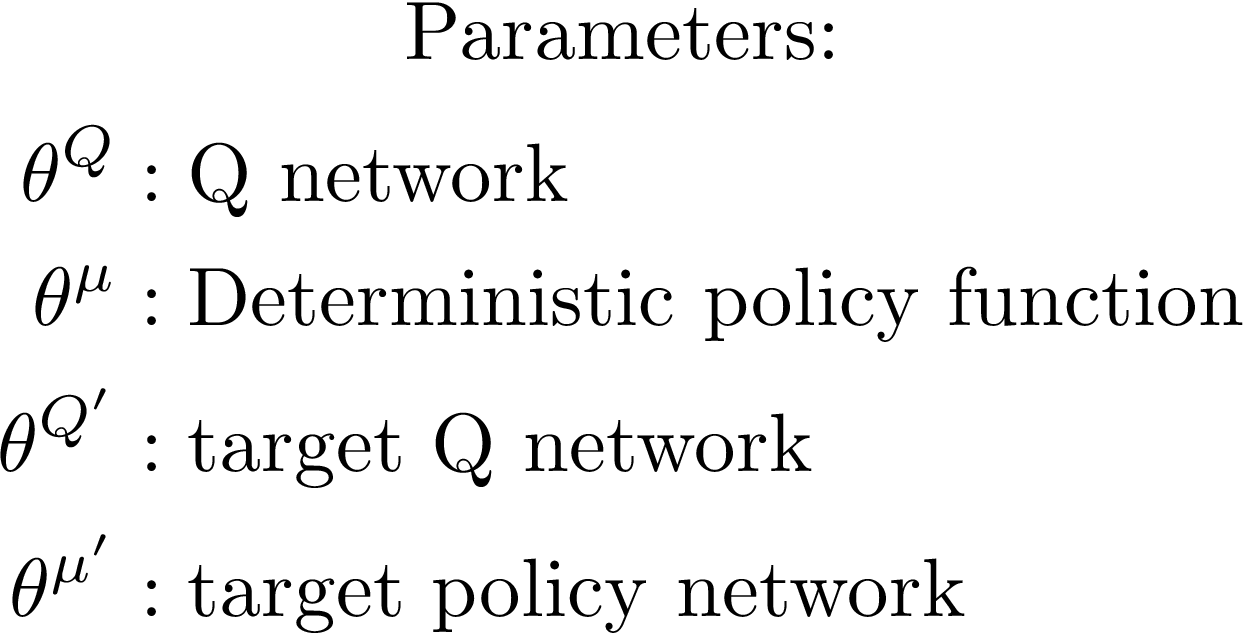



The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space.

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning.

Let's create these networks.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

Now, let's create the DDPG agent. The agent class has two main functions: "get_action" and "update":



*   **get_action()**: This function runs a forward pass through the actor network to select a determinisitic action. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930), thereby resulting in exploration in the environment. Class OUNoise (in cell 1) implements this.


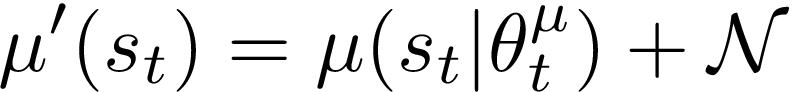



*   **update()**: This function is used for updating the actor and critic networks, and forms the core of the DDPG algorithm. The replay buffer is first sampled to get a batch of experiences of the form **<states, actions, rewards, next_states>**.

The value network is updated similarly as is done in Q-learning. The updated Q value is obtained by the Bellman equation. However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the updated Q value and the original Q value:

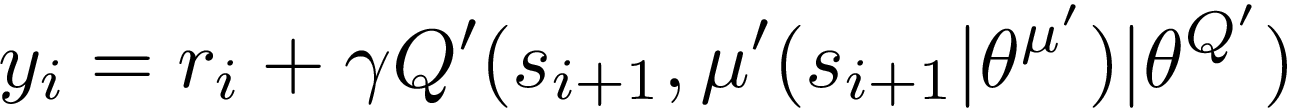

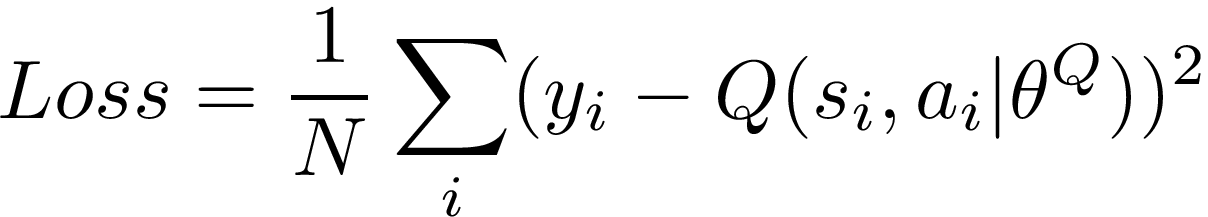

For the policy function, our objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. Keep in mind that the actor (policy) function is differentiable, so we have to apply the chain rule.

But since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:

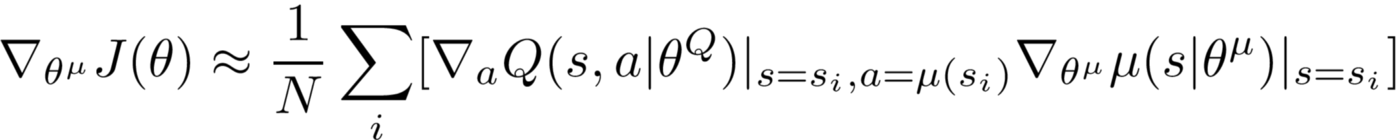

We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:

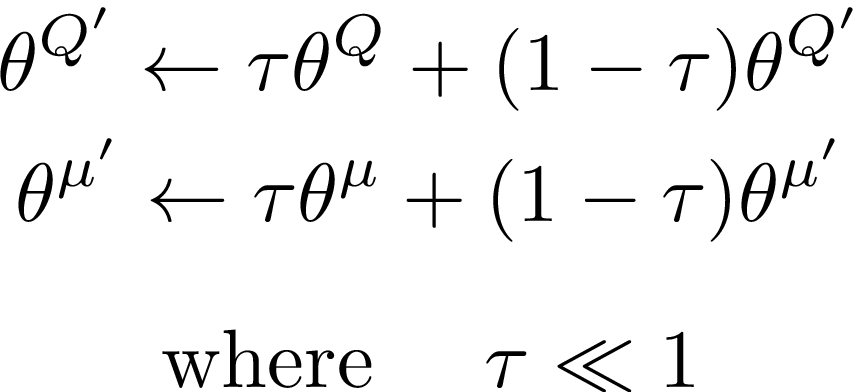






In [10]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
# from model import *
# from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-4, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions) # policy network
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions) # policy target
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # Q network
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # Q target network

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            target_param.requires_grad = False

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        # Implement critic loss and update critic - using Q (value) network
        actionsNext = self.actor_target(next_states)
        QtargetsNext = self.critic_target(next_states, actionsNext)
        # Compute Q targets for current states (y_i)
        QTargets = rewards + (self.gamma * QtargetsNext)
        # Compute critic loss
        QExpected = self.critic(states, actions)
        criticLoss = self.critic_criterion(QExpected, QTargets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        criticLoss.backward()
        self.critic_optimizer.step()

        # Implement actor loss and update actor - use policy gradient
        actionsPred = self.actor(states)
        actorLoss = -self.critic(states, actionsPred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actorLoss.backward()
        self.actor_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

*Putting* it all together: DDPG in action.

The main function below runs 50 episodes of DDPG on the "Pendulum-v1" environment of OpenAI gym. This is the inverted pendulum swingup problem, a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

Each episode is for a maximum of 500 timesteps. At each step, the agent chooses an action, updates its parameters according to the DDPG algorithm and moves to the next state, repeating this process till the end of the episode.

The DDPG algorithm is as follows:

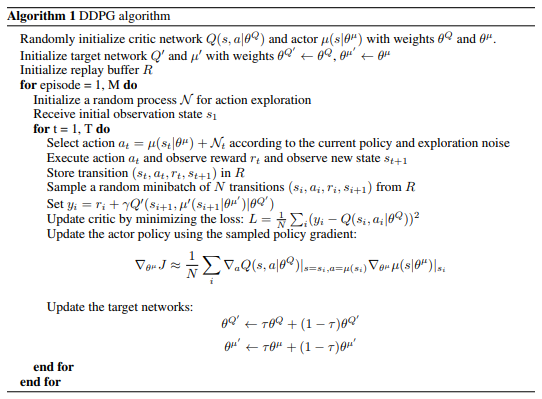

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/

episode: 0, reward: -1454.81, average _reward: nan 
episode: 1, reward: -1673.16, average _reward: -1454.8097858075191 
episode: 2, reward: -1524.7, average _reward: -1563.985606954312 
episode: 3, reward: -1568.45, average _reward: -1550.889631287923 
episode: 4, reward: -1499.93, average _reward: -1555.2791456184393 
episode: 5, reward: -1318.71, average _reward: -1544.2102173378712 
episode: 6, reward: -1395.08, average _reward: -1506.6262727985795 
episode: 7, reward: -1386.71, average _reward: -1490.6907327267174 
episode: 8, reward: -1431.26, average _reward: -1477.6926982900898 
episode: 9, reward: -1315.74, average _reward: -1472.5338773349422 
episode: 10, reward: -1390.72, average _reward: -1456.8542951690042 
episode: 11, reward: -1388.75, average _reward: -1450.4455594806302 
episode: 12, reward: -594.62, average _reward: -1422.0048045307626 
episode: 13, reward: -269.9, average _reward: -1328.9965499382474 
episode: 14, reward: -504.09, average _reward: -1199.1412932161572

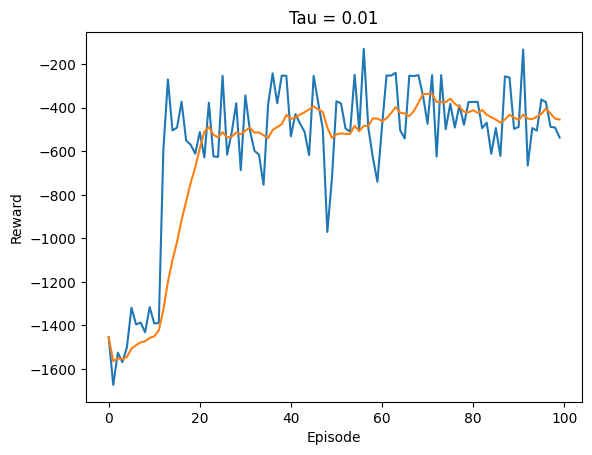

In [15]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))
tauUsed = 1e-2
agent = DDPGagent(env,tau=tauUsed)
noise = OUNoise(env.action_space)

batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.title('Tau = '+str(tauUsed))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

episode: 0, reward: -1134.51, average _reward: nan 
episode: 1, reward: -1265.06, average _reward: -1134.510178572632 
episode: 2, reward: -1248.99, average _reward: -1199.784889500355 
episode: 3, reward: -1670.6, average _reward: -1216.1873432087618 
episode: 4, reward: -1662.96, average _reward: -1329.7909544235047 
episode: 5, reward: -1634.61, average _reward: -1396.423791779266 
episode: 6, reward: -1565.65, average _reward: -1436.1209224621073 
episode: 7, reward: -1390.39, average _reward: -1454.625269489787 
episode: 8, reward: -1551.35, average _reward: -1446.595902852158 
episode: 9, reward: -1614.16, average _reward: -1458.235620809088 
episode: 10, reward: -1599.52, average _reward: -1473.8282494402247 
episode: 11, reward: -1472.56, average _reward: -1520.329325175896 
episode: 12, reward: -1556.18, average _reward: -1541.0798068287409 
episode: 13, reward: -1440.9, average _reward: -1571.7982328912715 
episode: 14, reward: -1590.18, average _reward: -1548.82816222116 
ep

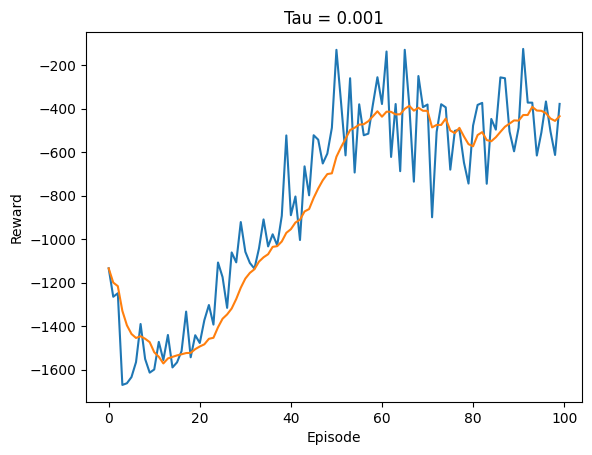

In [16]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))
tauUsed = 1e-3
agent = DDPGagent(env,tau=tauUsed)
noise = OUNoise(env.action_space)

batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.title('Tau = '+str(tauUsed))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

episode: 0, reward: -1134.45, average _reward: nan 
episode: 1, reward: -1515.46, average _reward: -1134.4474104846097 
episode: 2, reward: -1376.32, average _reward: -1324.9557815320672 
episode: 3, reward: -754.82, average _reward: -1342.0755225106952 
episode: 4, reward: -768.9, average _reward: -1195.262366563884 
episode: 5, reward: -1008.21, average _reward: -1109.989682176832 
episode: 6, reward: -837.96, average _reward: -1093.0266334218811 
episode: 7, reward: -1501.24, average _reward: -1056.5883688551608 
episode: 8, reward: -1418.15, average _reward: -1112.1699942729424 
episode: 9, reward: -1546.04, average _reward: -1146.1679675383925 
episode: 10, reward: -1623.39, average _reward: -1186.1555607095038 
episode: 11, reward: -1591.21, average _reward: -1235.0494641004111 
episode: 12, reward: -1621.9, average _reward: -1242.624194619891 
episode: 13, reward: -1288.31, average _reward: -1267.1823874441338 
episode: 14, reward: -1389.61, average _reward: -1320.5306690629182 

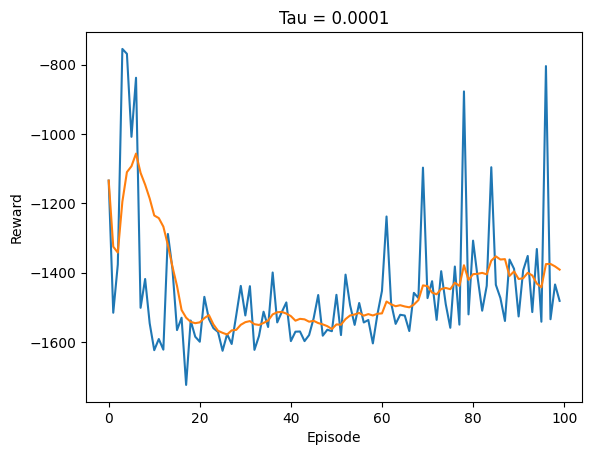

In [17]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))
tauUsed = 1e-4
agent = DDPGagent(env,tau=tauUsed)
noise = OUNoise(env.action_space)

batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.title('Tau = '+str(tauUsed))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

episode: 0, reward: -1216.35, average _reward: nan 
episode: 1, reward: -1430.16, average _reward: -1216.3522922627665 
episode: 2, reward: -1133.79, average _reward: -1323.2568077306637 
episode: 3, reward: -1636.55, average _reward: -1260.1017533218921 
episode: 4, reward: -1469.53, average _reward: -1354.2137701482166 
episode: 5, reward: -1162.32, average _reward: -1377.27626080852 
episode: 6, reward: -1430.97, average _reward: -1341.45095056204 
episode: 7, reward: -1254.64, average _reward: -1354.2386930120158 
episode: 8, reward: -1291.05, average _reward: -1341.7889322492451 
episode: 9, reward: -1407.76, average _reward: -1336.1508391516272 
episode: 10, reward: -1721.43, average _reward: -1343.3116694120695 
episode: 11, reward: -1517.51, average _reward: -1393.8191154230367 
episode: 12, reward: -1084.75, average _reward: -1402.554183870265 
episode: 13, reward: -1329.4, average _reward: -1397.6497587241338 
episode: 14, reward: -948.97, average _reward: -1366.934843688423 

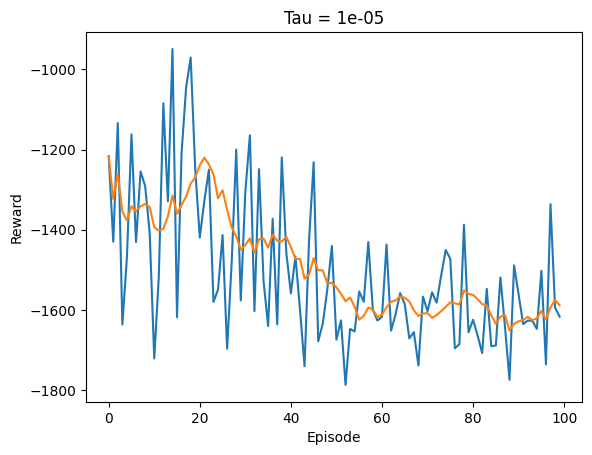

In [18]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))
tauUsed = 1e-5
agent = DDPGagent(env,tau=tauUsed)
noise = OUNoise(env.action_space)

batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.title('Tau = '+str(tauUsed))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [19]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object): # for adding noise to the action prediced by the policy network
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        gaussian_noise = np.random.normal(0,1)
        return np.clip(action + gaussian_noise, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b



class Memory: # contains replay buffer/experience array
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

episode: 0, reward: -1765.0, average _reward: nan 
episode: 1, reward: -1644.96, average _reward: -1765.0034827389843 
episode: 2, reward: -1624.89, average _reward: -1704.9840659467914 
episode: 3, reward: -1535.37, average _reward: -1678.2863609499243 
episode: 4, reward: -1663.26, average _reward: -1642.5574507015103 
episode: 5, reward: -1569.14, average _reward: -1646.6987184653092 
episode: 6, reward: -1740.2, average _reward: -1633.7728802846875 
episode: 7, reward: -1704.89, average _reward: -1648.9766318038053 
episode: 8, reward: -1624.32, average _reward: -1655.9657510039713 
episode: 9, reward: -1117.51, average _reward: -1652.4491958966269 
episode: 10, reward: -1751.36, average _reward: -1598.9548766174448 
episode: 11, reward: -1608.46, average _reward: -1597.5908166906397 
episode: 12, reward: -1702.19, average _reward: -1593.9405085041633 
episode: 13, reward: -1673.59, average _reward: -1601.670592337688 
episode: 14, reward: -1715.66, average _reward: -1615.492984206

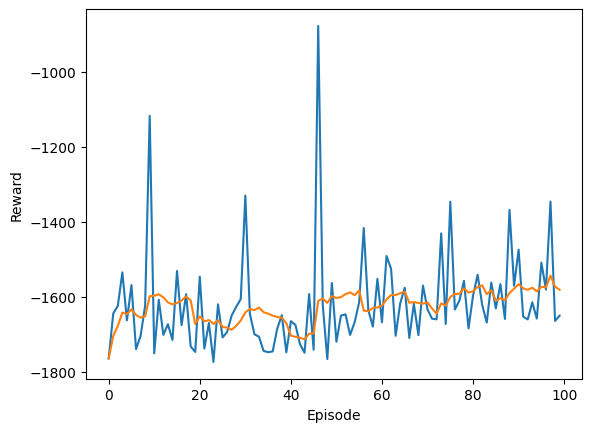

In [20]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)

batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0

    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action

        action = noise.get_action(action)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, new_state, done)

        if len(agent.memory) > batch_size:
            agent.update(batch_size)

        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#### Inference



1.   DDPG algorithms are used in environments with conitnuous action space, making it ideal for use with the Inverted Pendulum environment used here.
2.   Along with the actions obtained from the Actor network, a small noise element is added.
3.   2 types of noise were tried - Ornstein-Ulhenbeck Process and Gaussian Noise
4.   With Ornstein-Ulhenbeck Process, 4 values of tau were used - 0.01, 0.001, 0.0001 and 0.00001 [Plots shown above].
5.   As tau value was decreased, the average reward obtained slowed down from episode to episode. Hence the network took longer to converge - hence increasing regret.
6.   This is due to the reduced levels of exploration observed with lower values of Tau.
7.   Under Gaussian noise, performance is much worse, than under Ornstein-Ulhenbeck Process.


